In [1]:
import random
import itertools
import collections
import subprocess
import json
from subprocess import STDOUT, run

def solve(args,clingo_exe='clingo'):
    """Run clingo with the provided argument list and return the parsed JSON result."""

    print_args = [clingo_exe] + list(args) + [' | tr [:space:] \\\\n | sort ']
    args = [clingo_exe, '--outf=2'] + args # + ["--sign-def=rnd","--seed="+str(random.randint(0,1<<30))] #No randomness here
    #print(' '.join(args))
    if False:
        with subprocess.Popen(
            ' '.join(args),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            shell=True
        ) as clingo:
            outb, err = clingo.communicate(timeout=15)
    else:
        outb = run(' '.join(args),capture_output=True, timeout=15).stdout
        
    #if err:
    #    print(err)
    out = outb.decode("utf-8")
    if len(out) == 0:
        print(f'Command "{" ".join(args)}" failed.')
    with open('dump.lp', 'w') as outfile:
        result = json.loads(out)
        witness = result['Call'][0]['Witnesses'][-1]['Value']
        for atom in sorted(witness):
            outfile.write(atom + '.\n')
    return parse_json_result(out) ,   

def parse_terms(arguments):
    terms = []
    while len(arguments) > 0:
        l_paren = arguments.find('(')
        r_paren = arguments.find(')')
        comma = arguments.find(',')
        if l_paren < 0:
            l_paren = len(arguments) - 1
        if r_paren < 0:
            r_paren = len(arguments) - 1
        if comma < 0:
            comma = len(arguments) - 1
        next = min(l_paren, r_paren, comma)
        next_c = arguments[next]
        if next_c == '(':

            pred = arguments[:next]
            sub_terms, arguments = parse_terms(arguments[next + 1:])
            terms.append({'predicate': pred, 'terms': sub_terms})
        elif next_c == ')':
            pred = arguments[:next]
            if pred != '':
                terms.append({'predicate': arguments[:next]})
            arguments = arguments[next + 1:]
            return terms, arguments
        elif next_c == ',':
            pred = arguments[:next]
            if pred != '':
                terms.append({'predicate': arguments[:next]})
            arguments = arguments[next + 1:]
        else:
            terms.append({'predicate': arguments})
            arguments = ''
    return terms, ''


def parse_json_result(out):
    """Parse the provided JSON text and extract a dict
    representing the predicates described in the first solver result."""
    result = json.loads(out)
    assert len(result['Call']) > 0
    assert len(result['Call'][0]['Witnesses']) > 0
    all_preds = []
    ids = list(range(len(result['Call'][0]['Witnesses'])))
    random.shuffle(ids)
    for id in ids[:]:
        witness = result['Call'][0]['Witnesses'][id]['Value']

        class identitydefaultdict(collections.defaultdict):
            def __missing__(self, key):
                return key

        preds = collections.defaultdict(list)
        env = identitydefaultdict()

        for atom in witness:
            parsed, dummy = parse_terms(atom)
            preds[parsed[0]['predicate']].append(parsed)
        all_preds.append(preds)
    return all_preds


In [2]:
%%time 
import numpy as np
import time
rules = 'no_age_sampling'

characters = 230
families = 8
data = []
for _ in range(3):
    for characters in [50,75,100,150,200,300]:
        for families in [5,10,20,40]:
            been_good = False
            for family_mod in [2,3,5,7,11, 13, 17, 19, 23, 29, 31, 37]:
                sample_ages = False
                if sample_ages:
                    ages = np.random.randn(characters,1)*35/2 + 35
                    ages[ages<=1] += 35
                    ages[ages>=70] -= 35
                    bit = True


                    with open('ages.lp','w') as outfile:
                        if bit:
                            rules = 'no_age_sampling'
                            for charID, age in enumerate(ages):
                                age = int(age)
                                bit = 0
                                while age > 0:
                                    if age % 2 == 1:
                                        outfile.write(f'age_bits(character({charID+1}),{bit}).')
                                    age = age // 2
                                    bit += 1
                        else:
                            rules = 'no_age_num'
                            for charID, age in enumerate(ages):
                                age = int(age)
                                outfile.write(f'age(character({charID+1}),{age}).')
                                print(age)

                old_way = False
                if old_way:
                    results = !clingo {rules} ages.lp  -n 1 -t 8 -c characters={characters}
                    age_bits = {}
                    for result in results:
                        for thing in sorted(result.split(' ')):
                            print(thing)
                            if True:
                                if 'age_bits' in thing[:9]:
                                    thing = thing[18:]
                                    char_id = thing.split(')')[0][1:]

                                    age_bit = thing.split(',')[1][:-1]
                                    age_bits[char_id] = age_bits.get(char_id,[]) + [int(age_bit)]

                    for char in age_bits:
                        age = 0
                        for bit in age_bits[char]:
                            age += 2**bit
                        print(char,age)
                else:
                    print(characters,families)
                    start = time.time()
                    #clingo {rules} ages.lp -t 8 -c characters={characters} -c families={families}
                    try:
                        solution = solve([rules, 'ages.lp','-n','1','-t','8','-c',f'characters={characters}','-c',f'families={families}',
                                     '-c',f'family_mod={family_mod}'])
                        print(f'{family_mod}:',time.time()-start)
                        data.append((characters,families,family_mod,time.time()-start))
                        been_good = True
                    except:
                        print(family_mod,'failed')
                        data.append((characters,families,family_mod,float('inf')))
                        if been_good:
                            break
            #!clingo dump.lp -t 8 residence_and_jobs.lp -c characters={characters}

50 5
2: 0.4999675750732422
50 5
3: 0.2276630401611328
50 5
5: 0.15677475929260254
50 5
7 failed
50 10
2: 1.7725012302398682
50 10
3: 1.0683836936950684
50 10
5: 0.4553182125091553
50 10
7 failed
50 20
2: 1.0512428283691406
50 20
3: 0.4468958377838135
50 20
5: 0.2440323829650879
50 20
7 failed
50 40
2: 2.045996904373169
50 40
3: 0.9701738357543945
50 40
5: 0.43601512908935547
50 40
7 failed
75 5
2: 2.1174402236938477
75 5
3: 1.5331306457519531
75 5
5: 0.7623507976531982
75 5
7 failed
75 10
2: 3.4863839149475098
75 10
3: 2.369389533996582
75 10
5: 0.8159182071685791
75 10
7 failed
75 20
2: 3.7711098194122314
75 20
3: 1.8429889678955078
75 20
5: 0.7519350051879883
75 20
7 failed
75 40
2: 5.82105016708374
75 40
3: 2.816318988800049
75 40
5: 0.7300775051116943
75 40
7 failed
100 5
2: 1.7563669681549072
100 5
3: 0.9181463718414307
100 5
5: 0.36057281494140625
100 5
7 failed
100 10
2: 3.5528788566589355
100 10
3: 1.2146694660186768
100 10
5: 0.539186954498291
100 10
7 failed
100 20
2: 5.24018

3: 0.9151179790496826
75 5
5: 0.4116787910461426
75 5
7 failed
75 10
2: 2.573742628097534
75 10
3: 1.3401901721954346
75 10
5: 0.6314077377319336
75 10
7 failed
75 20
2: 3.9157698154449463
75 20
3: 2.0663318634033203
75 20
5: 0.8536152839660645
75 20
7 failed
75 40
2: 6.509002685546875
75 40
3: 2.830665111541748
75 40
5: 1.0123376846313477
75 40
7 failed
100 5
2: 3.1585586071014404
100 5
3: 1.546990156173706
100 5
5: 0.6859662532806396
100 5
7 failed
100 10
2: 3.18137526512146
100 10
3: 1.7677075862884521
100 10
5: 1.1507203578948975
100 10
7 failed
100 20
2: 5.33100438117981
100 20
3: 2.5911011695861816
100 20
5: 1.266333818435669
100 20
7 failed
100 40
2: 10.033859729766846
100 40
3: 9.394727230072021
100 40
5: 3.0039749145507812
100 40
7 failed
150 5
2: 11.258197546005249
150 5
3: 3.500765085220337
150 5
5: 1.5575220584869385
150 5
7: 0.6855487823486328
150 5
11: 0.28073596954345703
150 5
13: 0.1919543743133545
150 5
17 failed
150 10
2: 9.447800874710083
150 10
3: 5.773433208465576


In [3]:
import matplotlib.pyplot as plt
import numpy as np
data = np.array(data)

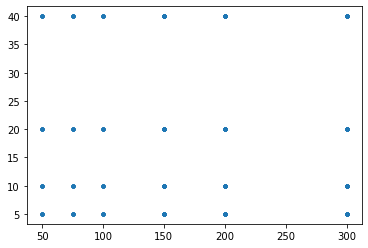

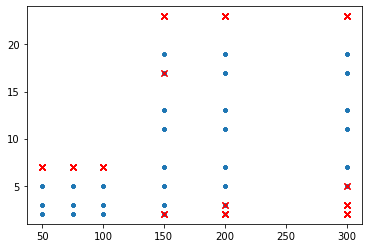

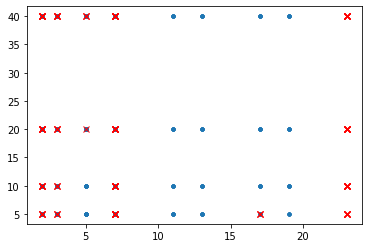

In [9]:
found = data[:,3] < float('inf')
bad = data[:,3] == float('inf')

plt.plot(data[found,0],data[found,1],'.')
plt.show()
plt.plot(data[found,0],data[found,2],'.')
plt.plot(data[bad,0],data[bad,2],'rx')
plt.show()
plt.plot(data[found,2],data[found,1],'.')
plt.plot(data[bad,2],data[bad,1],'rx')
plt.show()

In [14]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(data[found,0].reshape(-1, 1),data[found,2].reshape(-1, 1))
print(reg.coef_)


[[0.04038287]]


25.0

7
1 1
2 3
3 4
4 4
5 4
6 3
7 1
8 1
9 3
10 4
11 4
12 4
13 3
14 1
15 1
16 3
17 4
18 4
19 4
20 3
21 1
22 1
23 3
24 4
25 4
26 4
27 3
28 1
29 1
30 3
31 4
32 4
33 4
34 3
35 1
36 1
37 3
38 4
39 4
40 4
41 3
42 1
43 1
44 3
45 4
46 4
47 4
48 3
49 1
50 1
51 3
52 4
53 4
54 4
55 3
56 1
57 1
58 3
59 4
60 4
61 4
62 3
63 1
64 1
65 3
66 4
67 4
68 4
69 3
70 1
71 1
72 3
73 4
74 4
75 4
76 3
77 1
78 1
79 3
80 4
81 4
82 4
83 3
84 1
85 1
86 3
87 4
88 4
89 4
90 3
91 1
92 1
93 3
94 4
95 4
96 4
97 3
98 1
99 1
100 3
5 59
4 57
3 56
2 56
1 56


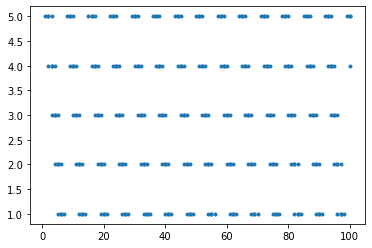

In [5]:
import matplotlib.pyplot as plt
import numpy as np

characters = 100
families = 5
primes = [2,3,5,7,11, 13, 17, 19, 23, 29, 31, 37]
mod = characters//20
for p in primes:
    if mod < p:
        mod = p
        break
print(mod)
points = []
f_coverage = {}
c_coverage = {}

for c in range(1,characters+1):
    for f in range(1,families+1):
        if (c+f)%mod < 2:
            points.append((c,f))
            c_coverage[c] = c_coverage.get(c,0) + 1
            f_coverage[f] = f_coverage.get(f,0) + 1
            
        if (c+f+1)%mod< 2:
            points.append((c,f))
            c_coverage[c] = c_coverage.get(c,0) + 1
            f_coverage[f] = f_coverage.get(f,0) + 1
            
for c in c_coverage:
    print(c,c_coverage[c])
    
for f in f_coverage:
    print(f,f_coverage[f])     
points = np.array(points)
plt.plot(points[:,0],points[:,1],'.')

In [6]:
bad = set()
good = set()
nums = {}
for ii in range(len(data)):
    ind = tuple(data[ii,:3])
    if data[ii,3] > 100:
        bad.add(ind)
    else:
        good.add(ind)
    nums[tuple(data[ii,:3])]


KeyError: (50.0, 5.0, 2.0)

In [ ]:
print(bad & good)

In [15]:
%%time 
import numpy as np
import time
rules = 'no_age_sampling'

characters = 230
families = 8
data = []
for characters in [50,75,100,150,200,300]:
    for families in [5,10,20,40]:
        sample_ages = False

        primes = [2,3,5,11, 13, 17, 19, 23, 29, 31, 37]
        mod = characters//25
        for p in primes:
            if mod < p:
                mod = p
                break
        family_mod = mod
        if sample_ages:
            ages = np.random.randn(characters,1)*35/2 + 35
            ages[ages<=1] += 35
            ages[ages>=70] -= 35
            bit = True


            with open('ages.lp','w') as outfile:
                if bit:
                    rules = 'no_age_sampling'
                    for charID, age in enumerate(ages):
                        age = int(age)
                        bit = 0
                        while age > 0:
                            if age % 2 == 1:
                                outfile.write(f'age_bits(character({charID+1}),{bit}).')
                            age = age // 2
                            bit += 1
                else:
                    rules = 'no_age_num'
                    for charID, age in enumerate(ages):
                        age = int(age)
                        outfile.write(f'age(character({charID+1}),{age}).')
                        print(age)

        old_way = False
        if old_way:
            results = !clingo {rules} ages.lp  -n 1 -t 8 -c characters={characters}
            age_bits = {}
            for result in results:
                for thing in sorted(result.split(' ')):
                    print(thing)
                    if True:
                        if 'age_bits' in thing[:9]:
                            thing = thing[18:]
                            char_id = thing.split(')')[0][1:]

                            age_bit = thing.split(',')[1][:-1]
                            age_bits[char_id] = age_bits.get(char_id,[]) + [int(age_bit)]

            for char in age_bits:
                age = 0
                for bit in age_bits[char]:
                    age += 2**bit
                print(char,age)
        else:
            print(characters,families)
            start = time.time()
            #clingo {rules} ages.lp -t 8 -c characters={characters} -c families={families}
            try:
                solution = solve([rules, 'ages.lp','-n','1','-t','8','-c',f'characters={characters}','-c',f'families={families}',
                             '-c',f'family_mod={family_mod}'])
                print(f'{family_mod}:',time.time()-start)
                data.append((characters,families,family_mod,time.time()-start))
            except:
                print(family_mod,'failed')
                data.append((characters,families,family_mod,float('inf')))
    #!clingo dump.lp -t 8 residence_and_jobs.lp -c characters={characters}

50 5
3: 0.37610602378845215
50 10
3: 0.3409614562988281
50 20
3: 0.5135407447814941
50 40
3: 1.0257604122161865
75 5
5: 0.23526811599731445
75 10
5: 0.32695531845092773
75 20
5: 0.4954700469970703
75 40
5: 0.8284435272216797
100 5
5: 0.4295361042022705
100 10
5: 0.6062006950378418
100 20
5: 0.8377766609191895
100 40
5: 1.2746706008911133
150 5
11: 0.23859930038452148
150 10
11: 0.41608238220214844
150 20
11: 0.6418089866638184
150 40
11: 0.9175243377685547
200 5
11: 0.36505818367004395
200 10
11: 0.834235429763794
200 20
11: 1.1432790756225586
200 40
11: 1.789102554321289
300 5
13: 0.581275463104248
300 10
13: 1.1705596446990967
300 20
13: 1.8818573951721191
300 40
13: 2.662026882171631
Wall time: 19.9 s
